In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100
sns.set_style('white')

def show_several(df):
    for j in df.index:
        print(j)
        show_one(j)
def show_one(j):
    try:
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    except Exception:
        return
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [29]:
df_full = pd.read_csv('../../export/hypers.csv')
df_full = df_full.set_index('job_id')

In [30]:
labels = [
    'emnist_digits_count',
    'emnist_letters_count',
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'ratio_unique',
    'innovative',
    'existing',
    'noisy',
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'red' if abs(val) < 0.2 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,emnist_digits_count,emnist_letters_count,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,ratio_unique,innovative,existing,noisy
emnist_digits_count,1,-0.23483,0.5255,-0.468059,0.390713,0.198077,-0.0262494,0.308614,0.1942,0.0221624,0.00436101,-0.127926
emnist_letters_count,-0.23483,1,-0.250408,0.352242,0.427953,0.540464,0.70224,0.449923,0.695972,0.315373,-0.263514,-0.545605
digits_count,0.5255,-0.250408,1,-0.908417,0.463885,0.345577,-0.0840875,0.422827,0.16139,0.223792,-0.154809,-0.333889
letters_count,-0.468059,0.352242,-0.908417,1,-0.380486,-0.261214,0.164145,-0.342722,-0.0601016,-0.182519,0.139717,0.242107
digits_objectness,0.390713,0.427953,0.463885,-0.380486,1,0.911601,0.671254,0.950801,0.876319,0.607705,-0.639648,-0.834755
letters_objectness,0.198077,0.540464,0.345577,-0.261214,0.911601,1,0.813666,0.947725,0.847799,0.763422,-0.778002,-0.934871
digits_and_letters_objectness,-0.0262494,0.70224,-0.0840875,0.164145,0.671254,0.813666,1,0.714854,0.803982,0.588909,-0.584553,-0.784529
emnist_objectness,0.308614,0.449923,0.422827,-0.342722,0.950801,0.947725,0.714854,1,0.841306,0.745017,-0.753256,-0.910904
ratio_unique,0.1942,0.695972,0.16139,-0.0601016,0.876319,0.847799,0.803982,0.841306,1,0.500156,-0.507678,-0.79519
innovative,0.0221624,0.315373,0.223792,-0.182519,0.607705,0.763422,0.588909,0.745017,0.500156,1,-0.9179,-0.880584


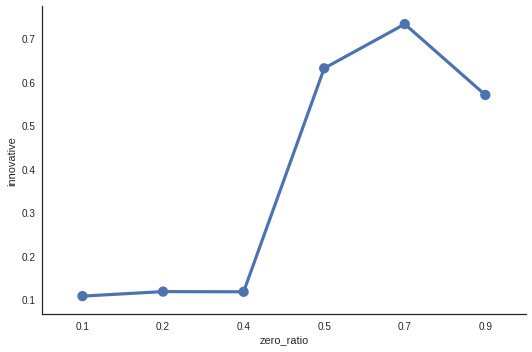

In [32]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==3]
#df = df[df['stride'] == 1]
#df = df[df['zero_ratio']!=0.4]
df = df.sort_values(by='zero_ratio')
sns.factorplot(x='zero_ratio', y='innovative', data=df, size=5, aspect=1.5)

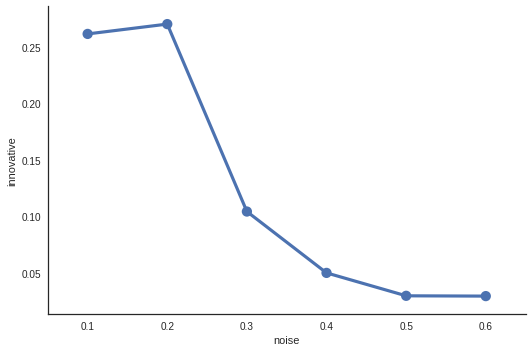

In [33]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df[df['noise']<=0.6]
df = df.sort_values(by='noise')
sns.factorplot(x='noise', y='innovative', data=df, size=5, aspect=1.5)

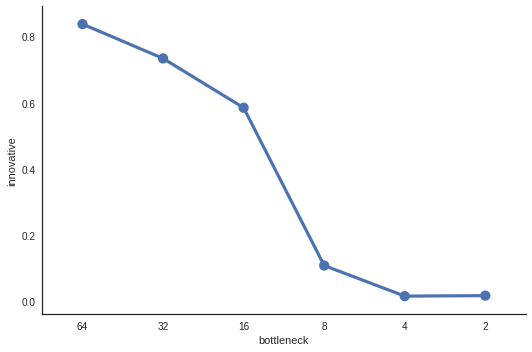

In [34]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df  = df[df['nb_layers']==4]
df = df.sort_values(by='bottleneck', ascending=False)
sns.factorplot(x='bottleneck', y='innovative', data=df, order=[64, 32, 16, 8, 4, 2], size=5, aspect=1.5)

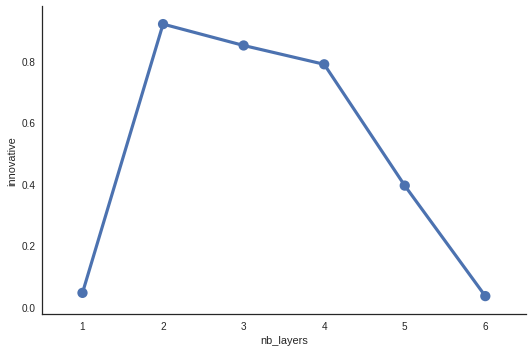

In [35]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==1]
sns.factorplot(x='nb_layers', y='innovative', data=df, size=5, aspect=1.5)

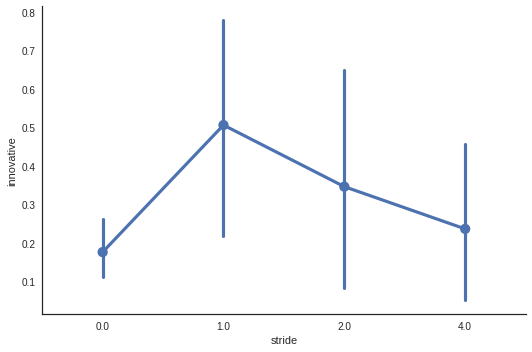

In [36]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
sns.factorplot(x='stride', y='innovative', data=df, size=5, aspect=1.5)

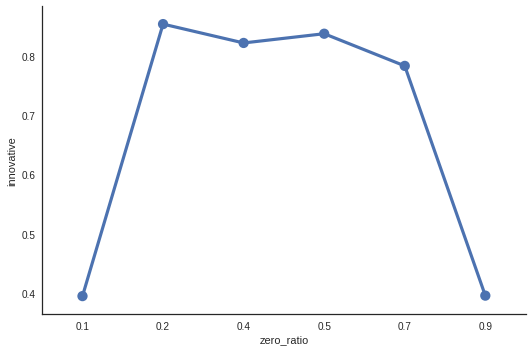

In [37]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel_stride']
df = df[df['nb_layers']==3]
df = df[df['stride'] == 1]
df = df.sort_values(by='zero_ratio')
sns.factorplot(x='zero_ratio', y='innovative', data=df, size=5, aspect=1.5)
#show_several(df)